# Compare GPs + Plot

In [1]:
import fastgps
import qmcpy as qp
import numpy as np
import torch
import pandas as pd
from matplotlib import pyplot
import tueplots.figsizes

In [2]:
device = "cpu"
if device!="mps":
    torch.set_default_dtype(torch.float64)

In [3]:
colors = ["xkcd:"+color[:-1] for color in pd.read_csv("../../../xkcd_colors.txt",comment="#").iloc[:,0].tolist()][::-1]
_alpha = 0.25
WIDTH = 2*(500/72)
LINEWIDTH = 3
MARKERSIZE = 100

## True Function

In [4]:
d = 1
def f_ackley(x, a=20, b=0.2, c=2*np.pi, scaling=32.768):
    # https://www.sfu.ca/~ssurjano/ackley.html
    assert x.ndim==2
    x = 2*scaling*x-scaling
    t1 = a*torch.exp(-b*torch.sqrt(torch.mean(x**2,1)))
    t2 = torch.exp(torch.mean(torch.cos(c*x),1))
    t3 = a+np.exp(1)
    y = -t1-t2+t3
    return y
fs = [lambda x: f_ackley(x,c=0), lambda x: f_ackley(x)]
num_tasks = len(fs)
n = torch.tensor([2**4,2**3],device=device)

## Parameters

In [5]:
seqs_std = [
    qp.DigitalNetB2(d,seed=11,randomize="DS"),
    qp.DigitalNetB2(d,seed=13,randomize="DS"),
]
seqs_lattice = [
    qp.Lattice(d,seed=7),
    qp.Lattice(d,seed=2),
 ]
seqs_dnb2s = [
    qp.DigitalNetB2(d,seed=7,randomize="DS"),
    qp.DigitalNetB2(d,seed=2,randomize="DS"),
]
ngptypes = 3

In [6]:
xticks = torch.linspace(0,1,1001,device=device)[1:-1,None]
yticks = torch.vstack([fs[i](xticks) for i in range(num_tasks)])

## Independent Single Task GPs

In [7]:
pmeans = [torch.empty((num_tasks,len(xticks))) for i in range(ngptypes)]
ci_lows = [torch.empty((num_tasks,len(xticks))) for i in range(ngptypes)]
ci_highs = [torch.empty((num_tasks,len(xticks))) for i in range(ngptypes)]
fgp_indep = [ 
    [
        fastgps.StandardGP(qp.KernelSquaredExponential(d=d,torchify=True,device=device),seqs=seqs_std[0]),
        fastgps.StandardGP(qp.KernelSquaredExponential(d=d,torchify=True,device=device),seqs=seqs_std[1]),
    ],
    [
        fastgps.FastGPLattice(qp.KernelShiftInvar(d=d,torchify=True,device=device),seqs=seqs_lattice[0]),
        fastgps.FastGPLattice(qp.KernelShiftInvar(d=d,torchify=True,device=device),seqs=seqs_lattice[1]),
    ],
    [
        fastgps.FastGPDigitalNetB2(qp.KernelDigShiftInvar(d=d,torchify=True,device=device),seqs=seqs_dnb2s[0]),
        fastgps.FastGPDigitalNetB2(qp.KernelDigShiftInvar(d=d,torchify=True,device=device),seqs=seqs_dnb2s[1]),
    ],
]
for i in range(ngptypes):
    print(type(fgp_indep[i][0]).__name__)
    for l in range(num_tasks):
        x_next = fgp_indep[i][l].get_x_next(n=n[l].item())
        y_next = torch.vstack([fs[i](x_next) for i in range(num_tasks)])
        fgp_indep[i][l].add_y_next(y_next[l])
        fgp_indep[i][l].fit()
        pmeans[i][l],_,_,ci_lows[i][l],ci_highs[i][l] = fgp_indep[i][l].post_ci(xticks)

StandardGP
     iter of 5.0e+03 | best loss  | loss      
    ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
            0.00e+00 | 1.18e+06   | 1.18e+06  
            5.00e+00 | 6.72e+05   | 6.72e+05  
            1.00e+01 | 8.46e+01   | 8.46e+01  
            1.50e+01 | 4.50e+01   | 4.52e+01  
            2.00e+01 | 4.48e+01   | 4.48e+01  
            2.50e+01 | 4.47e+01   | 4.47e+01  
            3.00e+01 | 4.47e+01   | 4.47e+01  
     iter of 5.0e+03 | best loss  | loss      
    ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
            0.00e+00 | 8.98e+05   | 8.98e+05  
            5.00e+00 | 4.58e+05   | 4.58e+05  
            1.00e+01 | 2.94e+01   | 2.94e+01  
            1.50e+01 | 2.59e+01   | 2.59e+01  
            2.00e+01 | 2.59e+01   | 2.59e+01  
            2.40e+01 | 2.59e+01   | 2.59e+01  
FastGPLattice
     iter of 5.0e+03 | best loss  | loss      
    ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
            0.00e+00 | 5.13e+02   | 5.13e+02  
            5.00e+00 | 1.27e+02   |

## Multi-Task Fast GPs

In [8]:
fgp_multitask = [
    fastgps.StandardGP(qp.KernelMultiTask(qp.KernelSquaredExponential(d,torchify=True,device=device),num_tasks=num_tasks),seqs=seqs_std),
    fastgps.FastGPLattice(qp.KernelMultiTask(qp.KernelShiftInvar(d,torchify=True,device=device),num_tasks=num_tasks),seqs=seqs_lattice),
    fastgps.FastGPDigitalNetB2(qp.KernelMultiTask(qp.KernelDigShiftInvar(d,torchify=True,device=device),num_tasks=num_tasks),seqs=seqs_dnb2s),
]
pmean_mt = [None for i in range(ngptypes)]
ci_low_mt = [None for i in range(ngptypes)]
ci_high_mt = [None for i in range(ngptypes)]
for i in range(ngptypes):
    print(type(fgp_multitask[i]).__name__)
    x_next = fgp_multitask[i].get_x_next(n=n)
    y_next = [fs[i](x_next[i]) for i in range(num_tasks)]
    fgp_multitask[i].add_y_next(y_next)
    fgp_multitask[i].fit()
    pmean_mt[i],_,_,ci_low_mt[i],ci_high_mt[i] = fgp_multitask[i].post_ci(xticks)

StandardGP
     iter of 5.0e+03 | best loss  | loss      
    ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
            0.00e+00 | 2.74e+06   | 2.74e+06  
            5.00e+00 | 7.86e+05   | 7.86e+05  
            1.00e+01 | 1.27e+02   | 1.27e+02  
            1.50e+01 | 6.81e+01   | 6.81e+01  
            2.00e+01 | 6.19e+01   | 6.19e+01  
            2.50e+01 | 5.92e+01   | 5.92e+01  
            3.00e+01 | 5.66e+01   | 5.66e+01  
            3.50e+01 | 5.59e+01   | 5.59e+01  
            4.00e+01 | 5.58e+01   | 5.58e+01  
            4.50e+01 | 5.58e+01   | 5.58e+01  
            4.60e+01 | 5.58e+01   | 5.58e+01  
FastGPLattice
     iter of 5.0e+03 | best loss  | loss      
    ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
            0.00e+00 | 3.15e+02   | 3.15e+02  
            5.00e+00 | 6.67e+01   | 6.67e+01  
            1.00e+01 | 5.98e+01   | 5.98e+01  
            1.50e+01 | 5.44e+01   | 5.44e+01  
            2.00e+01 | 5.11e+01   | 5.11e+01  
            2.50e+01 | 5.11e+01   |

## Plot

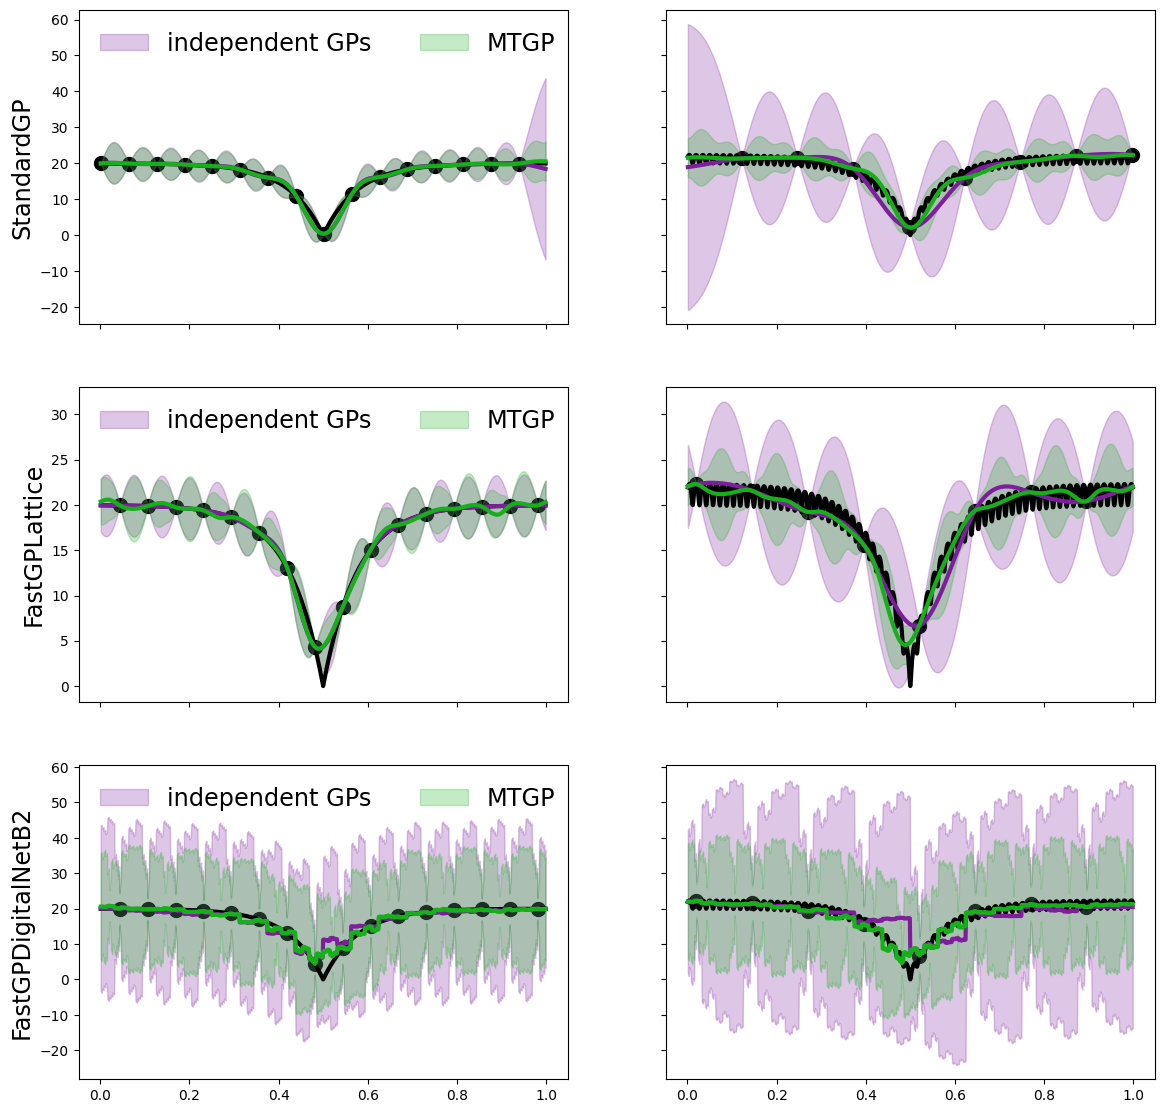

In [9]:
fig,ax = pyplot.subplots(nrows=ngptypes,ncols=num_tasks,figsize=(WIDTH,WIDTH/num_tasks*ngptypes/1.5),sharex=True,sharey="row")
ax = ax.reshape((ngptypes,num_tasks))
for i in range(ngptypes):
    for l in range(num_tasks):
        ax[i,l].plot(xticks[:,0].cpu(),yticks[l].cpu(),color="k",linewidth=LINEWIDTH)
        ax[i,l].scatter(fgp_indep[i][l].x[:,0].cpu(),fgp_indep[i][l].y.cpu(),color="k",s=MARKERSIZE)
    pltmin = min([ci_lows[i][l].min() for l in range(num_tasks)]+[ci_low_mt[i].min()])
    pltmax = max([ci_highs[i][l].max() for l in range(num_tasks)]+[ci_high_mt[i].max()])
    ax[i,0].set_ylim([pltmin-.05*(pltmax-pltmin),pltmax+.05*(pltmax-pltmin)])
    ax[i,0].set_ylabel(type(fgp_multitask[i]).__name__,fontsize="xx-large")
fig.savefig("./mtgps0.pdf",bbox_inches="tight")
for i in range(ngptypes):
    for l in range(num_tasks):
        ax[i,l].plot(xticks[:,0].cpu(),pmeans[i][l].cpu(),color=colors[0],linewidth=LINEWIDTH)
        ax[i,l].fill_between(xticks[:,0].cpu(),ci_lows[i][l].cpu(),ci_highs[i][l].cpu(),color=colors[0],alpha=_alpha,label="independent GPs")
    ax[i,0].legend(frameon=False,loc="upper left",ncols=2,fontsize="xx-large") 
fig.savefig("./mtgps1.pdf",bbox_inches="tight")
for i in range(ngptypes):
    for l in range(num_tasks):
        ax[i,l].plot(xticks[:,0].cpu(),pmean_mt[i][l].cpu(),color=colors[1],linewidth=LINEWIDTH)
        ax[i,l].fill_between(xticks[:,0].cpu(),ci_low_mt[i][l].cpu(),ci_high_mt[i][l].cpu(),color=colors[1],alpha=_alpha,label="MTGP")
    ax[i,0].legend(frameon=False,loc="upper left",ncols=2,fontsize="xx-large") 
fig.savefig("./mtgps2.pdf",bbox_inches="tight")